# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

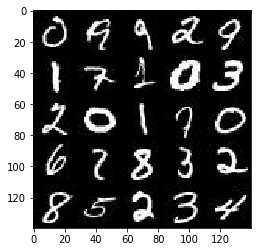

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

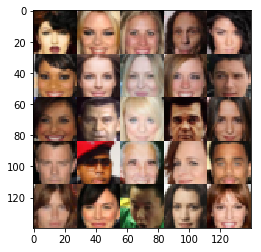

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x 1/3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        # 28x28x128 Now
        
        # Output Layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        # 28x28x3 Now
        
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, depth = data_shape
    input_real, input_z, learning_rate_ = model_inputs(width, height, depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizer
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, depth, data_image_mode)
                    
        #saver.save(sess, './checkpoints/generator.ckpt')
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7145... Generator Loss: 1.2958
Epoch 1/2... Discriminator Loss: 1.8497... Generator Loss: 2.4999
Epoch 1/2... Discriminator Loss: 1.5117... Generator Loss: 1.4601
Epoch 1/2... Discriminator Loss: 1.6506... Generator Loss: 1.1283
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 1.2507
Epoch 1/2... Discriminator Loss: 1.4515... Generator Loss: 1.1854
Epoch 1/2... Discriminator Loss: 1.4899... Generator Loss: 1.3075
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 1.2231
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 1.1972
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 1.1906


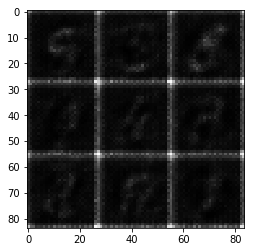

Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 1.1817
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 1.3445
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 1.3228
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 1.4395
Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 1.4060
Epoch 1/2... Discriminator Loss: 1.1776... Generator Loss: 1.6876
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 1.4927
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 1.4712
Epoch 1/2... Discriminator Loss: 1.1751... Generator Loss: 1.5717
Epoch 1/2... Discriminator Loss: 1.1761... Generator Loss: 1.8142


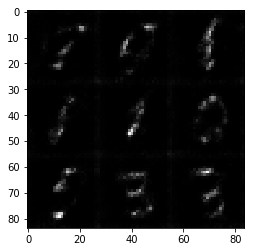

Epoch 1/2... Discriminator Loss: 1.0651... Generator Loss: 1.4902
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 1.3340
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 1.7624
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 1.8465
Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 1.5494
Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 1.9096
Epoch 2/2... Discriminator Loss: 1.2152... Generator Loss: 1.3530
Epoch 2/2... Discriminator Loss: 1.1917... Generator Loss: 1.2537
Epoch 2/2... Discriminator Loss: 1.1598... Generator Loss: 1.3200
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 1.5388


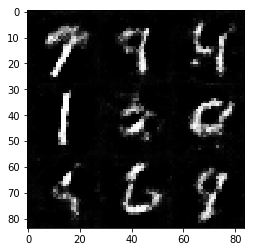

Epoch 2/2... Discriminator Loss: 1.1701... Generator Loss: 1.0680
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 1.4053
Epoch 2/2... Discriminator Loss: 1.2834... Generator Loss: 1.3588
Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 1.2938
Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 1.3581
Epoch 2/2... Discriminator Loss: 1.2278... Generator Loss: 1.3512
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 1.2520
Epoch 2/2... Discriminator Loss: 1.2095... Generator Loss: 1.1374
Epoch 2/2... Discriminator Loss: 1.2890... Generator Loss: 1.3768
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 1.3464


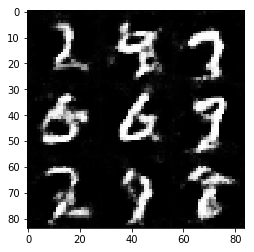

Epoch 2/2... Discriminator Loss: 1.2379... Generator Loss: 1.3734
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 1.2423
Epoch 2/2... Discriminator Loss: 1.1734... Generator Loss: 1.0841
Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 1.3323
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 1.2874
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 1.3448


In [14]:
batch_size = 256
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 2.4399
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 2.2833
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 2.2770
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 1.9969
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 1.6024


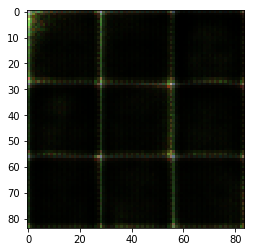

Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 2.5930
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 3.4540
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 3.6381
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 5.6869
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 4.4354
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 3.3798
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 4.4055
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.7504
Epoch 1/1... Discriminator Loss: 2.1151... Generator Loss: 0.2176
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 2.0851


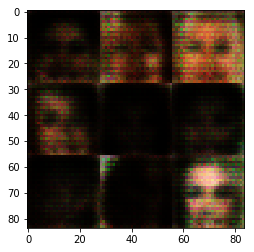

Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 5.0907
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 4.3862
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 3.2839
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 1.5384
Epoch 1/1... Discriminator Loss: 1.7802... Generator Loss: 0.3275
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.9138
Epoch 1/1... Discriminator Loss: 1.7549... Generator Loss: 0.3005
Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 0.3180
Epoch 1/1... Discriminator Loss: 0.4983... Generator Loss: 2.7906


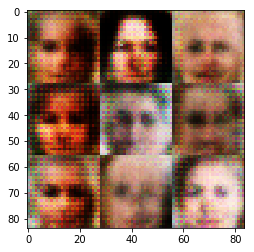

Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 2.0444
Epoch 1/1... Discriminator Loss: 2.0170... Generator Loss: 2.4776
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 0.6658... Generator Loss: 1.6448
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 2.8977
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.8143


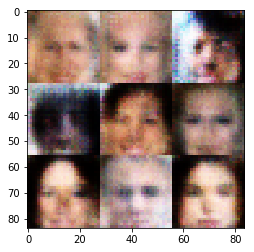

Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 2.4074
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.2802
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.6621
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 1.8882
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.2506
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 1.1263


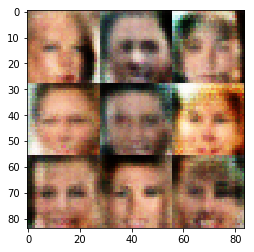

Epoch 1/1... Discriminator Loss: 0.5727... Generator Loss: 2.1575
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.3774
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 1.4584
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.6027
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.4272
Epoch 1/1... Discriminator Loss: 1.6936... Generator Loss: 0.3216
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 2.0404


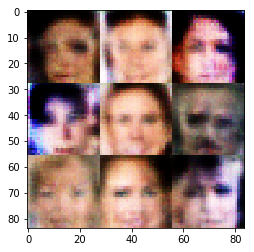

Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.8000... Generator Loss: 2.5752
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7437


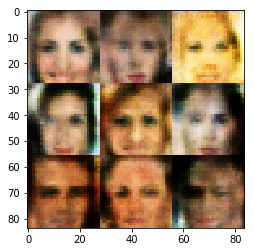

Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 1.5790
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 1.3446


In [15]:
batch_size = 256
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.